<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1R2HwbQCulKm-8FGok0mQM7jbnlz22Ikk?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
  

# Universidad del Tolima                                                   
## Facultad de Ingeniería Forestal 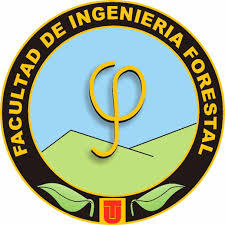
## Curso de hidrogeología y modelación de aguas subterráneas
## Unidad 1
## Práctico 1
## Modelacion de la interacción entre aguas superficiales y aguas
##   subterráneas bajo escenarios de extracción por bombeo

##Preparado por [Dr. Ing. Cristian Guevara-Ochoa]




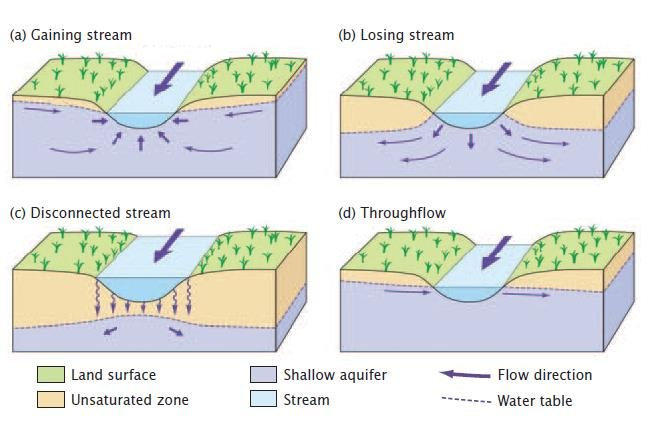

La celda 1 importa el módulo os que proporciona funciones para interactuar con el sistema operativo.

In [ ]:
import os

La celda 2 importa sys y usa sys.version para imprimir la versión de Python en uso, lo cual es útil para garantizar compatibilidad de código.

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


 La celda 3 descarga el archivo ejecutable del modelo MODFLOW 6 desde Google Drive usando su enlace compartido.

In [ ]:
!gdown 'https://drive.google.com/uc?export=download&id=1qzeHA6Zg-I9BEnvLtup12MGR20swHhf_'



Downloading...
From: https://drive.google.com/uc?export=download&id=1qzeHA6Zg-I9BEnvLtup12MGR20swHhf_
To: /content/mf6
100% 6.76M/6.76M [00:00<00:00, 53.7MB/s]


La celda 4 cambia los permisos del archivo mf6 para hacerlo ejecutable y luego lo mueve a /usr/local/bin para que pueda ser accedido desde cualquier parte del sistema.

In [ ]:
!chmod 755 ./mf6
!cp ./mf6 /usr/local/bin

La celda5 instala flopy, una biblioteca de Python usada para crear, ejecutar, y post-procesar modelos de MODFLOW, un software de modelado hidrogeológico.

In [ ]:
pip install flopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00


La celda 6 verifica que flopy está instalado correctamente e imprime la versión para documentar la compatibilidad del código.

In [ ]:
import flopy
print('flopy version:', flopy.__version__)

flopy version: 3.8.1


La celda 7 instala GitPython, una biblioteca que permite interactuar con repositorios de Git a través de Python.

In [ ]:
pip install GitPython

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


La celda 8 instala herramientas de desarrollo para trabajar con MODFLOW, facilitando la creación y manipulación de modelos.

In [ ]:
pip install modflow-devtools

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 9 importa varios módulos y configura las rutas del entorno de trabajo, verificando si el script se ejecuta dentro de un repositorio git o en un directorio común.

In [ ]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Aquí se define el nombre de la simulación sim_name y se intenta localizar el directorio raíz del repositorio Git. Si no se encuentra, se utiliza el directorio de trabajo actual. Se configuran las rutas para el espacio de trabajo, las figuras y los datos.

sim_name = "ex-gwf-bcf2ss"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 10 establece parámetros esenciales del modelo como unidades de longitud y tiempo, parámetros de la simulación como el número de capas, filas, columnas, y condiciones de contorno. Además, define las propiedades hidráulicas y las condiciones iniciales del acuífero.

In [ ]:
# Model units
length_units = "feet"
time_units = "days"

# Load the wetdry array for layer 1
fname = "wetdry01.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:3a4b357b7d2cd5175a205f3347ab973d",
)
wetdry_layer0 = np.loadtxt(fpath)

# Scenario-specific parameters
parameters = {
    "ex-gwf-bcf2ss-p01a": {
        "rewet": True,
        "wetfct": 1.0,
        "iwetit": 1,
        "ihdwet": 0,
        "linear_acceleration": "cg",
        "newton": None,
    },
    "ex-gwf-bcf2ss-p02a": {
        "rewet": False,
        "wetfct": None,
        "iwetit": None,
        "ihdwet": None,
        "linear_acceleration": "bicgstab",
        "newton": "NEWTON",
    },
}

# Model parameters
nper = 2  # Number of periods
nlay = 2  # Number of layers
nrow = 10  # Number of rows
ncol = 15  # Number of columns
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 150.0  # Top of the model ($ft$)
botm_str = "50.0, -50."  # Layer bottom elevations ($ft$)
icelltype_str = "1, 0"  # Cell conversion type
k11_str = "10.0, 5.0"  # Horizontal hydraulic conductivity ($ft/d$)
k33 = 0.1  # Vertical hydraulic conductivity ($ft/d$)
strt = 0.0  # Starting head ($ft$)
recharge = 0.004  # Recharge rate ($ft/d$)

# Time discretization
tdis_ds = (
    (1.0, 1.0, 1),
    (1.0, 1.0, 1),
)

# Parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]

# Well boundary conditions
wel_spd = {
    1: [
        [1, 2, 3, -35000.0],
        [1, 7, 3, -35000.0],
    ]
}

# River boundary conditions
riv_spd = {0: [[1, i, 14, 0.0, 10000.0, -5] for i in range(nrow)]}

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-6
rclose = 1e-3
relax = 0.97

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 11 establece las definiciones de funciones clave para construir, escribir y ejecutar el modelo.

In [ ]:
def build_models(name, rewet, wetfct, iwetit, ihdwet, linear_acceleration, newton):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration=linear_acceleration,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
        relaxation_factor=relax,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, save_flows=True, newtonoptions=newton
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    if rewet:
        rewet_record = [
            "wetfct",
            wetfct,
            "iwetit",
            iwetit,
            "ihdwet",
            ihdwet,
        ]
        wetdry = [wetdry_layer0, 0]
    else:
        rewet_record = None
        wetdry = None

    flopy.mf6.ModflowGwfnpf(
        gwf,
        rewet_record=rewet_record,
        wetdry=wetdry,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 12 contiene la definición de la función para generar gráficos de los resultados del modelo numerico

In [ ]:
# Figure properties
figure_size = (6, 6)


def plot_simulated_results(num, gwf, ho, co, silent=True):
    with styles.USGSMap():
        botm_arr = gwf.dis.botm.array

        fig = plt.figure(figsize=(6.8, 6), constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        ax1 = fig.add_subplot(gs[:3, :5])
        ax2 = fig.add_subplot(gs[:3, 5:], sharey=ax1)
        ax3 = fig.add_subplot(gs[3:6, :5], sharex=ax1)
        ax4 = fig.add_subplot(gs[3:6, 5:], sharex=ax1, sharey=ax1)
        ax5 = fig.add_subplot(gs[6, :])
        axes = [ax1, ax2, ax3, ax4, ax5]

        labels = ("A", "B", "C", "D")
        aquifer = ("Upper aquifer", "Lower aquifer")
        cond = ("natural conditions", "pumping conditions")
        vmin, vmax = -10, 140
        masked_values = [1e30, -1e30]
        levels = [
            np.arange(0, 130, 10),
            (10, 20, 30, 40, 50, 55, 60),
        ]
        plot_number = 0
        for idx, totim in enumerate(
            (
                1,
                2,
            )
        ):
            head = ho.get_data(totim=totim)
            head[head < botm_arr] = -1e30
            qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
                co.get_data(text="DATA-SPDIS", kstpkper=(0, totim - 1))[0],
                gwf,
            )

            for k in range(nlay):
                ax = axes[plot_number]
                ax.set_aspect("equal")
                mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=k)
                mm.plot_grid(lw=0.5, color="0.5")
                cm = mm.plot_array(
                    head, masked_values=masked_values, vmin=vmin, vmax=vmax
                )
                mm.plot_bc(ftype="WEL", kper=totim - 1)
                mm.plot_bc(ftype="RIV", color="green", kper=0)
                mm.plot_vector(qx, qy, normalize=True, color="0.75")
                cn = mm.contour_array(
                    head,
                    masked_values=masked_values,
                    levels=levels[idx],
                    colors="black",
                    linewidths=0.5,
                )
                plt.clabel(cn, fmt="%3.0f")
                heading = f"{aquifer[k]} under\n{cond[totim - 1]}"
                styles.heading(ax, letter=labels[plot_number], heading=heading)
                styles.remove_edge_ticks(ax)

                plot_number += 1

        # set axis labels
        ax1.set_ylabel("y-coordinate, in feet")
        ax3.set_ylabel("y-coordinate, in feet")
        ax3.set_xlabel("x-coordinate, in feet")
        ax4.set_xlabel("x-coordinate, in feet")

        # legend
        ax = axes[-1]
        ax.set_ylim(1, 0)
        ax.set_xlim(-5, 5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        # items for legend
        ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="green",
            mec="black",
            mew=0.5,
            label="River",
        )
        ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="red",
            mec="black",
            mew=0.5,
            label="Well",
        )
        ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="none",
            mec="black",
            mew=0.5,
            label="Dry cell",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        # ax.plot(
        #     -1000,
        #     -1000,
        #     lw=0.5,
        #     color="black",
        #     label="Head, in feet",
        # )
        styles.graph_legend(
            ax,
            ncol=5,
            frameon=False,
            loc="upper center",
        )

        cbar = plt.colorbar(
            cm, ax=ax, shrink=0.5, orientation="horizontal", location="bottom"
        )
        cbar.ax.set_xlabel("Head, in feet")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-{num:02d}.png")


def plot_results(silent=True):
    if not plot:
        return

    if silent:
        verbosity_level = 0
    else:
        verbosity_level = 1

    with styles.USGSMap():
        name = list(parameters.keys())[0]
        sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation.load(
            sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
        )
        gwf = sim.get_model(sim_name)

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # create MODFLOW 6 cell-by-cell budget object
        cobj = gwf.output.budget()

        # extract heads
        head = hobj.get_data(totim=1)

        # plot grid
        fig = plt.figure(figsize=(6.8, 3.5), constrained_layout=True)
        gs = mpl.gridspec.GridSpec(nrows=8, ncols=10, figure=fig, hspace=40, wspace=10)
        plt.axis("off")

        ax = fig.add_subplot(gs[:7, 0:7])
        ax.set_aspect("equal")
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        mm.plot_bc(ftype="WEL", kper=1, plotAll=True)
        mm.plot_bc(ftype="RIV", color="green", plotAll=True)
        mm.plot_grid(lw=0.5, color="0.5")
        ax.set_ylabel("y-coordinate, in feet")
        ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, letter="A", heading="Map view")
        styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(gs[:5, 7:])
        mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 7})
        mm.plot_array(np.ones((nlay, nrow, ncol)), head=head, cmap="jet")
        mm.plot_bc(ftype="WEL", kper=1)
        mm.plot_bc(ftype="RIV", color="green", head=head)
        mm.plot_grid(lw=0.5, color="0.5")
        ax.set_ylabel("Elevation, in feet")
        ax.set_xlabel("x-coordinate along \nrow 8, in feet")
        styles.heading(ax, letter="B", heading="Cross-section view")
        styles.remove_edge_ticks(ax)

        # items for legend
        ax = fig.add_subplot(gs[7, :])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)
        ax.plot(
            -1100,
            -1100,
            "s",
            ms=5,
            color="green",
            mec="black",
            mew=0.5,
            label="River",
        )
        ax.plot(
            -1100,
            -1100,
            "s",
            ms=5,
            color="red",
            mec="black",
            mew=0.5,
            label="Well",
        )
        ax.plot(
            -1100,
            -1100,
            "s",
            ms=5,
            color="blue",
            mec="black",
            mew=0.5,
            label="Steady-state water table",
        )
        styles.graph_legend(
            ax,
            ncol=3,
            frameon=False,
            loc="upper center",
        )

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)

        # figure with wetdry array
        fig = plt.figure(figsize=(4.76, 3), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect("equal")
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        wd = mm.plot_array(wetdry_layer0)
        mm.plot_grid(lw=0.5, color="0.5")
        cbar = plt.colorbar(wd, shrink=0.5)
        cbar.ax.set_ylabel("WETDRY parameter")
        ax.set_ylabel("y-coordinate, in feet")
        ax.set_xlabel("x-coordinate, in feet")
        styles.remove_edge_ticks(ax)

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-01.png")

        # plot simulated rewetting results
        plot_simulated_results(2, gwf, hobj, cobj)

        # plot simulated newton results
        name = list(parameters.keys())[1]
        sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation.load(
            sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
        )
        gwf = sim.get_model(sim_name)

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # create MODFLOW 6 cell-by-cell budget object
        cobj = gwf.output.budget()

        # plot the newton results
        plot_simulated_results(3, gwf, hobj, cobj)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 13 permite ejecutar diferentes escenarios del modelo de flujo subterráneo basados en un conjunto de parámetros predefinidos.

In [ ]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La celda 14 ejecuta el primer escenario de simulación (índice 0) en la lista de parámetros

In [ ]:
scenario(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


run_models took 48.79 ms


La celda 15 se encarga de visualizar los resultados simulados del modelo numerico

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


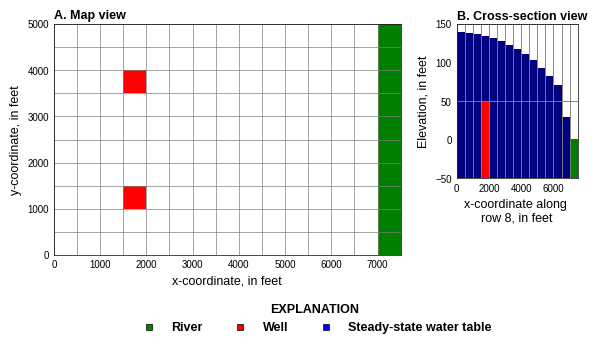

<ipython-input-12-c93744dfcbc5>:257: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(fpth)


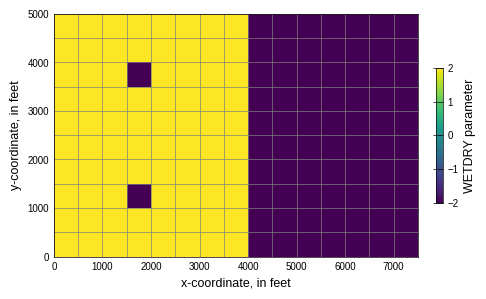

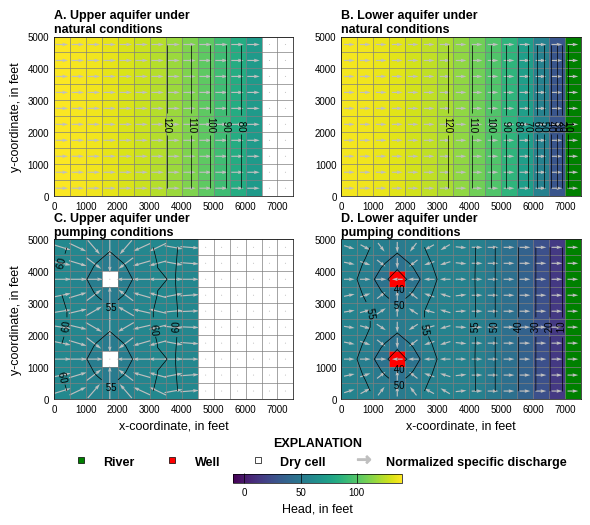

MFDataException: An error occurred in package "None". The error occurred while loading package file in the "load" method.
Additional Information:
(1) File /content/ex-gwf-bcf2ss-p02a/mfsim.nam of type nam could not be opened.

In [ ]:
if plot:
    # Simulated water levels and normalized specific discharge vectors in the
    # upper and lower aquifers under natural and pumping conditions using (1) the
    # rewetting option in the Node Property Flow (NPF) Package with the
    # Standard Conductance Formulation and (2) the Newton-Raphson formulation.
    # A. Upper aquifer results under natural conditions. B. Lower aquifer results
    # under natural conditions C. Upper aquifer results under pumping conditions.
    # D. Lower aquifer results under pumping conditions
    plot_results()